# Results 2c: Metric Validation

In [1]:
import os
import numpy as np
from pandas import read_csv
from tqdm import tqdm

## Section 1: Load and prepare data

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
scores = read_csv(os.path.join('data','scores.csv'))
items = read_csv(os.path.join('data','items.csv'))

## Restrict participants.
metrics = read_csv(os.path.join('data', 'metrics.csv'))
scores = scores[scores.subject.isin(metrics.subject)].reset_index(drop=True)
items = items[items.subject.isin(metrics.subject)].reset_index(drop=True)

## Merge DataFrames.
data = items.merge(scores).merge(metrics[['platform','subject','infreq']])

## Re-format infrequency.
data['infreq'] = np.where(data['infreq'] > 0, 1, 0)

## Compute binarized SHAPS scores.
data['shaps_binarized'] = np.where(data.filter(regex='shaps_') >= 2, 1, 0).sum(axis=1)

## Section 2: Cronbach's Alpha

In [3]:
from scipy.stats import ttest_rel
from numba import njit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
order = ['7u','7d','gad7','bis','bas','shaps','pswq']

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

@njit
def cronbach_alpha(X):
    "Estimate Cronbach's alpha for X, [n_obs, n_features]"
    n, k = X.shape
    C = np.cov(X.T)
    return (k / (k - 1)) * (1 - np.trace(C) / np.sum(C))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
alpha_0 = np.zeros(len(order))
alpha_1 = np.zeros(len(order))

## Iteratively compute Cronbach's alpha.
for i, subscale in enumerate(order):
    cols = items.filter(regex=f'{subscale}_').columns
    alpha_0[i] = cronbach_alpha(data.loc[data.infreq==0,cols].values)
    alpha_1[i] = cronbach_alpha(data.loc[data.infreq==1,cols].values)
    
## Compute test statistic.
tval, _ = ttest_rel(alpha_0, alpha_1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space
null_tvals = np.zeros(n_iter)

## Main loop.
permuted = data.copy()
for n in tqdm(range(n_iter)):
    
    ## Preallocate space.
    alpha_null = np.zeros((2, len(order))) 
    
    ## Permute rows of infrequncy score.
    permuted.infreq = np.random.permutation(permuted.infreq)
    
    ## Iteratively compute Cronbach's alpha.
    for i, subscale in enumerate(order):
        cols = items.filter(regex=f'{subscale}_').columns
        alpha_null[0,i] = cronbach_alpha(permuted.loc[permuted.infreq==0,cols].values)
        alpha_null[1,i] = cronbach_alpha(permuted.loc[permuted.infreq==1,cols].values)
        
    ## Compute test statistic.
    null_tvals[n], _ = ttest_rel(alpha_null[0], alpha_null[1])
    
## Compute p-value.
pval = (np.abs(tval) <= np.abs(null_tvals)).sum() / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Report Cronbach's alpha.
print('Attentive:', alpha_0.round(3))
print('Careless:', alpha_1.round(3))

## Report permutation test results.
print('tval = %0.3f, pval = %0.3f' %(tval,pval))

100%|██████████| 5000/5000 [02:25<00:00, 34.26it/s]

Attentive: [0.836 0.937 0.924 0.83  0.843 0.904 0.934]
Careless: [0.838 0.882 0.872 0.624 0.712 0.812 0.807]
tval = 3.689, pval = 0.021


## Section 3: Rates of Clinical Endorsement 

In [4]:
from pandas import DataFrame
from scipy.stats import skew

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define clinical cutoffs.
cutoffs = {
    '7u':12, 
    '7d':12, 
    'gad7':10, 
    'bis':np.nan, 
    'bas':np.nan, 
    'shaps':3, 
    'pswq':11
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute summary statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
table = np.zeros((len(order), 7))

## Iteratively compute summary statistics.
for i, (k, v) in enumerate(cutoffs.items()):
    
    ## Compute skew of score distribution.
    table[i,0] = skew(data[k])
    
    ## Compute total scores.
    table[i,1:3] = data.groupby('infreq')[k].mean()
    
    ## Compute proportion at threshold.
    if k == 'shaps': k = 'shaps_binarized'
    table[i,3] = (data[k] >= v).mean()
    table[i,4] = (data.query('infreq == 0')[k] >= v).mean()
        
## Store Cronbach alpha.
table[:,5] = alpha_0
table[:,6] = alpha_1

## Convert to DataFrame.
table = DataFrame(table, index=['7u','7d','GAD7','BIS','BAS','SHAPS','PSWQ'],
                  columns=['Skew','Score-A','Score-C','Cutoff-A','Cutoff-C','Alpha-A','Alpha-C'])

## Format DataFrame.
for col, fmt in zip(table.columns, [2,2,2,2,2,2,2]):
    table[col] = [f'%0.{fmt}f' %x if x else '-' for x in table[col]]

## Print LaTeX.
print(table.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &  Skew & Score-A & Score-C & Cutoff-A & Cutoff-C & Alpha-A & Alpha-C \\
\midrule
7u    &  0.81 &    3.87 &   10.15 &     0.13 &     0.04 &    0.84 &    0.84 \\
7d    &  0.76 &    4.75 &   10.68 &     0.17 &     0.09 &    0.94 &    0.88 \\
GAD7  &  0.75 &    4.86 &    9.73 &     0.26 &     0.17 &    0.92 &    0.87 \\
BIS   &  0.78 &    7.74 &    7.92 &        - &        - &    0.83 &    0.62 \\
BAS   &  0.17 &   15.73 &   16.16 &        - &        - &    0.84 &    0.71 \\
SHAPS &  0.26 &    8.02 &   10.85 &     0.18 &     0.15 &    0.90 &    0.81 \\
PSWQ  &  0.19 &    4.78 &    6.74 &     0.07 &     0.07 &    0.93 &    0.81 \\
\bottomrule
\end{tabular}



## Section 4: 1-PL model w/ Random Intercepts

#### 4.1: Load and prepare data

In [5]:
from pandas import read_csv

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load StanFit summary.
f = os.path.join('stan_results','1pl_logistic_summary.tsv')
df = read_csv(f, sep='\t', index_col='name')

## Extract random intercepts.
intercepts = df.T.filter(regex='Z\[[0-9]*,1\]').loc['Mean']

## Extract contrast statistics.
contrasts = df.T.filter(regex='contrasts')

## Print contrast stastics.
print('Attentive: %0.3f' %contrasts.loc['Mean','contrasts[1]'])
print('Careless: %0.3f' %contrasts.loc['Mean','contrasts[2]'])
print('Contrast: %0.3f, 95%% hdi = [%0.3f, %0.3f]' %(contrasts.loc['Mean','contrasts[3]'], 
                                                     contrasts.loc['5%','contrasts[3]'], 
                                                     contrasts.loc['95%','contrasts[3]']))

Attentive: -0.160
Careless: 0.450
Contrast: -0.610, 95% hdi = [-0.700, -0.520]


#### 4.2 Plotting

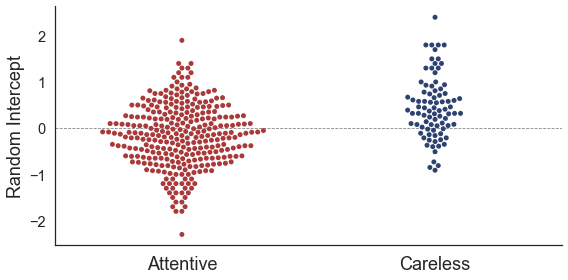

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Define aesthetics.
palette = ['#AA3939','#2E4272']

## Plot distribution of intercepts.
ax = sns.swarmplot(x=data.infreq.values, y=intercepts, palette=palette, ax=ax)
ax.axhline(0, lw=0.8, linestyle='--', color='0.5', zorder=-1)

## Add details.
ax.set_xticklabels(['Attentive','Careless'], fontsize=18)
ax.set_ylabel('Random Intercept', fontsize=18)

sns.despine()
plt.tight_layout()